In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from Autoencoders import ConformalAutoencoder, ScaledIsometricAutoencoder

import optuna.visualization as vis
import optuna
import optunahub

from torchvision.datasets import MNIST
from torchvision import transforms

from metrics import evaluate_conformality

import pandas as pd

random_state = 42
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

/home/dgalperi/anaconda3/envs/max/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda:1


In [2]:
class Encoder(nn.Module):
    def __init__(self, in_channels, latent_dim):
        super(Encoder, self).__init__()
        #input dim = 1, 32, 32
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 8, 3, stride=1, padding=1),  # (8, 32, 32)
            nn.ELU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),  # (16, 16, 16)
            nn.ELU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # (32, 8, 8)
            nn.ELU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # (64, 4, 4)
            nn.ELU(True),
        )

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 256),  # Flatten to (256,)
            nn.ELU(True),
            nn.Linear(256, 128),  # Flatten to (128,)
            nn.ELU(True),
            nn.Linear(128, latent_dim)  # Output latent dimension
        )
    
    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

class Decoder(nn.Module):
    def __init__(self, out_channels, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 128),  # Input latent dimension
            nn.ELU(True),
            nn.Linear(128, 256),  # Input latent dimension
            nn.ELU(True),
            nn.Linear(256, 64 * 4 * 4),  # Output size to reshape
            nn.ELU(True),
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # (32, 8, 8)
            nn.ELU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # (16, 16, 16)
            nn.ELU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),  # (8, 32, 32)
            nn.ELU(True),
            nn.ConvTranspose2d(8, out_channels, 3, stride=1, padding=1),  # (out_channels, 32, 32)
            nn.Sigmoid()  # For pixel values between 0 and 1
        )
    
    def forward(self, z):
        z = self.fc(z)
        z = torch.unflatten(z, 1, (64, 4, 4))  # Reshape to (64, 4, 4)
        z = self.deconv(z)
        return z

In [3]:
mnist = MNIST(root='data', train=True, download=True, transform=None)
data, labels = mnist.data, mnist.targets
data = data[labels == 3][:3000]
labels = labels[labels == 3]
data = torch.tensor(data, dtype=torch.float32).to(device)
data = transforms.Resize((32, 32))(data)  # Resize to 32x32
data = data / 255.0  # Normalize the images to [0, 1]
data = data.view(data.size(0), 1, 32, 32)  # Add channel dimension
mnist_val = MNIST(root='data', train=False, download=True, transform=None)
val_data, val_labels = mnist_val.data, mnist_val.targets
val_data = val_data[val_labels == 3][:1000]
val_labels = val_labels[val_labels == 3]
val_data = torch.tensor(val_data, dtype=torch.float32).to(device)
val_data = transforms.Resize((32, 32))(val_data)  # Resize to 32x32
val_data = val_data / 255.0  # Normalize the images to [0, 1]
val_data = val_data.view(val_data.size(0), 1, 32, 32)  # Add channel dimension

/tmp/ipykernel_1460053/315428273.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float32).to(device)
/tmp/ipykernel_1460053/315428273.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_data = torch.tensor(val_data, dtype=torch.float32).to(device)


In [4]:
encoder = Encoder(in_channels=1, latent_dim=24).to(device)
decoder = Decoder(latent_dim=24, out_channels=1).to(device)

In [4]:
from metrics import evaluate_conformality, conformality_cosine_loss, conformality_cosine_orthounit_loss, conformality_trace_loss, conformality_trace2_loss, regularization


lambda_conf = 0.12233
lambda_reg = 0.0211
conf_loss = "cosine" #trial.suggest_categorical("conformality_loss", ["trace","trace2", "cosine"]) #["trace","trace2", "cosine", "cosine2"]
lambda_aug = 0.1
lambda_conf_schedule = None
lambda_reg_schedule = None
num_samples_conf = 1
num_samples_reg = 1

epochs = 1000
batch_size = 256
latent_dim = 24
learning_rate = 0.001
scheduler_kwargs={"step_size": 100, "gamma": 0.7}

train_dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

encoder = Encoder(in_channels=1, latent_dim=latent_dim).to(device)
decoder = Decoder(latent_dim=latent_dim, out_channels=1).to(device)
conformal_autoencoder = ConformalAutoencoder(encoder, decoder,
                                                lambda_conf=lambda_conf, lambda_reg=lambda_reg, lambda_aug=lambda_aug,
                                                lambda_conf_schedule=lambda_conf_schedule, lambda_reg_schedule=lambda_reg_schedule
                                            ).to(device)

if conf_loss == "trace":
    conformal_autoencoder.conformality_loss = lambda func, z: conformality_trace_loss(func, z, num_samples=num_samples_conf)
elif conf_loss == "trace2":
    conformal_autoencoder.conformality_loss = lambda func, z: conformality_trace2_loss(func, z, num_samples=num_samples_conf)
elif conf_loss == "cosine":
    conformal_autoencoder.conformality_loss = conformality_cosine_loss
elif conf_loss == "cosine2":
    conformal_autoencoder.conformality_loss = conformality_cosine_orthounit_loss
else:
    conformal_autoencoder.conformality_loss = lambda func, z: 0.0

conformal_autoencoder.regularization_loss = lambda func, z: regularization(func, z, num_samples=num_samples_reg) #lambda func, z: 0.0


optimizer, scheduler = conformal_autoencoder.train_model(train_dataloader, val_dataloader, batch_size=batch_size,
                                                            epochs=epochs, learning_rate=learning_rate, log_every=epochs+1, val_every=epochs+1,
                                                            scheduler_kwargs=scheduler_kwargs)

stats, _ = evaluate_conformality(conformal_autoencoder, val_data[:1000])

stats['reconstruction_error'], np.abs(stats['log_determinant_vs_estimate_mean'])

(0.00273775402456522, np.float64(0.6197678446769714))

In [7]:
conformal_autoencoder.save_checkpoint("conformal_autoencoder_comparison1.pth")

Checkpoint saved to conformal_autoencoder_comparison1.pth at epoch 1001


In [28]:
conformal_autoencoder = ConformalAutoencoder(encoder, decoder).to(device)
conformal_autoencoder.load_model_from_checkpoint("conformal_autoencoder_comparison1.pth")

Model and custom variables loaded from conformal_autoencoder_comparison1.pth


ConformalAutoencoder(
  (encoder): Encoder(
    (conv): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ELU(alpha=True)
      (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ELU(alpha=True)
      (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): ELU(alpha=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): ELU(alpha=True)
    )
    (fc): Sequential(
      (0): Linear(in_features=1024, out_features=256, bias=True)
      (1): ELU(alpha=True)
      (2): Linear(in_features=256, out_features=128, bias=True)
      (3): ELU(alpha=True)
      (4): Linear(in_features=128, out_features=24, bias=True)
    )
  )
  (decoder): Decoder(
    (fc): Sequential(
      (0): Linear(in_features=24, out_features=128, bias=True)
      (1): ELU(alpha=True)
      (2): Linear(in_features=128, out_features=256, bias=True)
      (3): ELU(alpha=True)
      (4):

In [29]:
stats, _ = evaluate_conformality(conformal_autoencoder, val_data[:1000])

In [11]:
from metrics import evaluate_conformality, conformality_cosine_loss, conformality_cosine_orthounit_loss, conformality_trace_loss, conformality_trace2_loss, regularization


lambda_conf2 = 1.6
lambda_reg2 = 0.01
conf_loss = "cosine" #trial.suggest_categorical("conformality_loss", ["trace","trace2", "cosine"]) #["trace","trace2", "cosine", "cosine2"]
lambda_aug = 0.1
lambda_conf_schedule = None
lambda_reg_schedule = None
num_samples_conf = 1
num_samples_reg = 1

epochs = 1000
batch_size = 256
latent_dim = 24
learning_rate = 0.001
scheduler_kwargs={"step_size": 100, "gamma": 0.7}

train_dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

encoder = Encoder(in_channels=1, latent_dim=latent_dim).to(device)
decoder = Decoder(latent_dim=latent_dim, out_channels=1).to(device)
conformal_autoencoder2 = ConformalAutoencoder(encoder, decoder,
                                                lambda_conf=lambda_conf2, lambda_reg=lambda_reg2, lambda_aug=lambda_aug,
                                                lambda_conf_schedule=lambda_conf_schedule, lambda_reg_schedule=lambda_reg_schedule
                                            ).to(device)

if conf_loss == "trace":
    conformal_autoencoder2.conformality_loss = lambda func, z: conformality_trace_loss(func, z, num_samples=num_samples_conf)
elif conf_loss == "trace2":
    conformal_autoencoder2.conformality_loss = lambda func, z: conformality_trace2_loss(func, z, num_samples=num_samples_conf)
elif conf_loss == "cosine":
    conformal_autoencoder2.conformality_loss = conformality_cosine_loss
elif conf_loss == "cosine2":
    conformal_autoencoder2.conformality_loss = conformality_cosine_orthounit_loss
else:
    conformal_autoencoder2.conformality_loss = lambda func, z: 0.0

conformal_autoencoder2.regularization_loss = lambda func, z: regularization(func, z, num_samples=num_samples_reg) #lambda func, z: 0.0


optimizer2, scheduler2 = conformal_autoencoder2.train_model(train_dataloader, val_dataloader, batch_size=batch_size,
                                                            epochs=epochs, learning_rate=learning_rate, log_every=epochs+1, val_every=epochs+1,
                                                            scheduler_kwargs=scheduler_kwargs)

stats2, _ = evaluate_conformality(conformal_autoencoder2, val_data[:1000])

stats2['reconstruction_error'], np.abs(stats2['log_determinant_vs_estimate_mean'])

(0.003628292353823781, np.float64(0.14600570499897003))

In [12]:
conformal_autoencoder2.save_checkpoint("conformal_autoencoder_comparison2.pth")

Checkpoint saved to conformal_autoencoder_comparison2.pth at epoch 1001


In [30]:
conformal_autoencoder2 = ConformalAutoencoder(encoder, decoder).to(device)
conformal_autoencoder2.load_model_from_checkpoint("conformal_autoencoder_comparison2.pth")

Model and custom variables loaded from conformal_autoencoder_comparison2.pth


ConformalAutoencoder(
  (encoder): Encoder(
    (conv): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ELU(alpha=True)
      (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ELU(alpha=True)
      (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): ELU(alpha=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): ELU(alpha=True)
    )
    (fc): Sequential(
      (0): Linear(in_features=1024, out_features=256, bias=True)
      (1): ELU(alpha=True)
      (2): Linear(in_features=256, out_features=128, bias=True)
      (3): ELU(alpha=True)
      (4): Linear(in_features=128, out_features=24, bias=True)
    )
  )
  (decoder): Decoder(
    (fc): Sequential(
      (0): Linear(in_features=24, out_features=128, bias=True)
      (1): ELU(alpha=True)
      (2): Linear(in_features=128, out_features=256, bias=True)
      (3): ELU(alpha=True)
      (4):

In [31]:
stats2, _ = evaluate_conformality(conformal_autoencoder2, val_data[:1000])

In [32]:
stats["lambda_conf"] = conformal_autoencoder.lambda_conf
stats2["lambda_conf"] = conformal_autoencoder2.lambda_conf
stats["lambda_reg"] = conformal_autoencoder.lambda_reg
stats2["lambda_reg"] = conformal_autoencoder2.lambda_reg
statses = [stats, stats2]

df = pd.DataFrame(statses)

In [34]:
styled_df = df.style \
    .background_gradient(subset=[
            'reconstruction_error',
            'diagonal_gini',
            'lambda_std',
            'lambda_std_normed',
            'off_diag_mean',
            'off_diag_norm',
            'off_diag_mean_normed',
            'off_diag_norm_normed',
            'jTj_minus_lambdaI_mean',
            'jTj_minus_lambdaI_norm',
            'jTj_minus_lambdaI_mean_normed',
            'jTj_minus_lambdaI_norm_normed',
            'determinant_vs_estimate_std',
            ], cmap='Reds') \
    .background_gradient(subset=[
        'determinant_vs_estimate_mean'
    ], cmap='Greens')\
    .background_gradient(subset=[
        'lambda_mean',
        'latent_std',
        'latent_std_max',
        'latent_std_min',
        'latent_norm',
    ], cmap='Blues')

styled_df

,reconstruction_error,diagonal_gini,lambda_mean,lambda_std,lambda_std_normed,lambda_factors_meanerror,lambda_factors_meanerror_normalized,off_diag_mean,off_diag_norm,off_diag_mean_normed,off_diag_norm_normed,jTj_minus_lambdaI_mean,jTj_minus_lambdaI_norm,jTj_minus_lambdaI_mean_normed,jTj_minus_lambdaI_norm_normed,determinant_vs_estimate_mean,determinant_vs_estimate_std,determinant_vs_estimate_meanerror,determinant_vs_estimate_estimate_mean,log_determinant_vs_estimate_mean,log_determinant_vs_estimate_std,log_determinant_vs_estimate_estimate_mean,latent_std,latent_std_max,latent_std_min,latent_norm,lambda_conf,lambda_reg
0,0.002738,0.041601,0.977268,0.078728,0.080560,0.051894,0.053101,0.040576,1.250748,0.042219,1.301401,0.042877,1.296677,0.044612,1.349139,1.793854,10.031083,1.796926,2.760434,2.267901,13.939442,4.487796,1.974218,2.883759,1.350735,655.944641,0.100000,0.000000
1,0.003628,0.022934,1.033635,0.080540,0.077919,0.055179,0.053384,0.022468,0.692636,0.022033,0.679201,0.023815,0.720755,0.023355,0.706831,0.165352,0.155470,0.165352,0.867023,0.844294,5.157572,4.687197,1.668699,2.297767,1.107667,465.499908,0.100000,0.000000


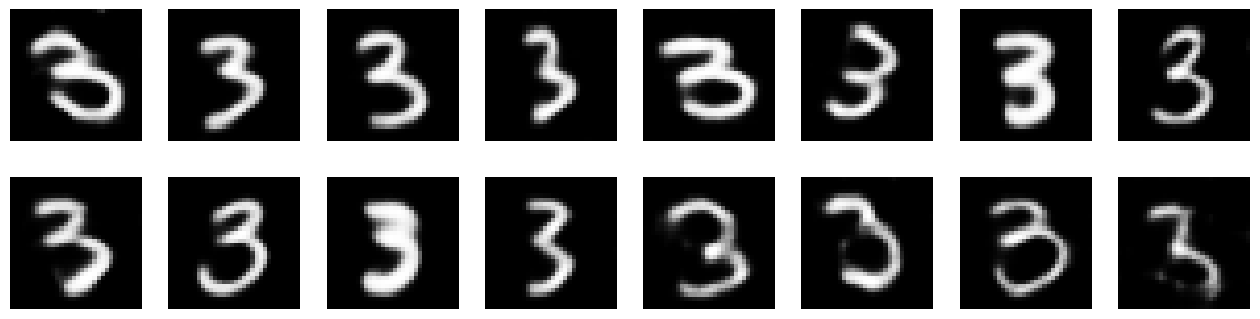

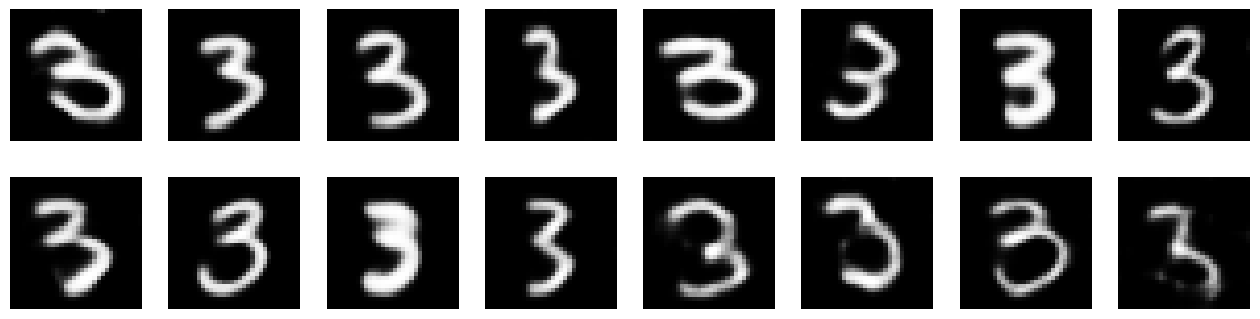

In [15]:
image_samples = conformal_autoencoder.forward(val_data[:16])
fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(image_samples[i].detach().cpu().numpy().squeeze(), cmap='gray')
    ax.axis('off')
plt.show()

image_samples = conformal_autoencoder2.forward(val_data[:16])
fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(image_samples[i].detach().cpu().numpy().squeeze(), cmap='gray')
    ax.axis('off')
plt.show()

In [5]:
latent_dim = 24
encoder = Encoder(in_channels=1, latent_dim=latent_dim).to(device)
decoder = Decoder(latent_dim=latent_dim, out_channels=1).to(device)
conformal_autoencoder = ConformalAutoencoder(encoder, decoder).to(device)
conformal_autoencoder.load_model_from_checkpoint("conformal_autoencoder_comparison1.pth")

encoder = Encoder(in_channels=1, latent_dim=latent_dim).to(device)
decoder = Decoder(latent_dim=latent_dim, out_channels=1).to(device)
conformal_autoencoder2 = ConformalAutoencoder(encoder, decoder).to(device)
conformal_autoencoder2.load_model_from_checkpoint("conformal_autoencoder_comparison2.pth")

encoder = Encoder(in_channels=1, latent_dim=latent_dim).to(device)
decoder = Decoder(latent_dim=latent_dim, out_channels=1).to(device)
isometric_autoencoder = ScaledIsometricAutoencoder(encoder, decoder).to(device)
isometric_autoencoder.load_model_from_checkpoint("isometric_autoencoder_comparison1.pth")

encoder = Encoder(in_channels=1, latent_dim=latent_dim).to(device)
decoder = Decoder(latent_dim=latent_dim, out_channels=1).to(device)
isometric_autoencoder2 = ScaledIsometricAutoencoder(encoder, decoder).to(device)
isometric_autoencoder2.load_model_from_checkpoint("isometric_autoencoder_comparison2.pth")

latent_dim = 24
encoder = Encoder(in_channels=1, latent_dim=latent_dim).to(device)
decoder = Decoder(latent_dim=latent_dim, out_channels=1).to(device)
conformal_autoencoder3 = ConformalAutoencoder(encoder, decoder).to(device)
conformal_autoencoder3.load_model_from_checkpoint("conformal_autoencoder_trace_comparison1.pth")

encoder = Encoder(in_channels=1, latent_dim=latent_dim).to(device)
decoder = Decoder(latent_dim=latent_dim, out_channels=1).to(device)
conformal_autoencoder4 = ConformalAutoencoder(encoder, decoder).to(device)
conformal_autoencoder4.load_model_from_checkpoint("conformal_autoencoder_trace_comparison2.pth")

Model and custom variables loaded from conformal_autoencoder_comparison1.pth
Model and custom variables loaded from conformal_autoencoder_comparison2.pth
Model and custom variables loaded from isometric_autoencoder_comparison1.pth
Model and custom variables loaded from isometric_autoencoder_comparison2.pth
Model and custom variables loaded from conformal_autoencoder_trace_comparison1.pth
Model and custom variables loaded from conformal_autoencoder_trace_comparison2.pth


ConformalAutoencoder(
  (encoder): Encoder(
    (conv): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ELU(alpha=True)
      (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ELU(alpha=True)
      (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): ELU(alpha=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): ELU(alpha=True)
    )
    (fc): Sequential(
      (0): Linear(in_features=1024, out_features=256, bias=True)
      (1): ELU(alpha=True)
      (2): Linear(in_features=256, out_features=128, bias=True)
      (3): ELU(alpha=True)
      (4): Linear(in_features=128, out_features=24, bias=True)
    )
  )
  (decoder): Decoder(
    (fc): Sequential(
      (0): Linear(in_features=24, out_features=128, bias=True)
      (1): ELU(alpha=True)
      (2): Linear(in_features=128, out_features=256, bias=True)
      (3): ELU(alpha=True)
      (4):

In [6]:
stats1, _ = evaluate_conformality(isometric_autoencoder, val_data[:1000])
stats2, _ = evaluate_conformality(isometric_autoencoder2, val_data[:1000])
stats3, _ = evaluate_conformality(conformal_autoencoder, val_data[:1000])
stats4, _ = evaluate_conformality(conformal_autoencoder2, val_data[:1000])
stats5, _ = evaluate_conformality(conformal_autoencoder3, val_data[:1000])
stats6, _ = evaluate_conformality(conformal_autoencoder4, val_data[:1000])

In [7]:
stats1["model"] = "isometric (recon))"
stats2["model"] = "isometric (conformality)"
stats3["model"] = "conformal angle (recon)"
stats4["model"] = "conformal angle (conformality)"
stats5["model"] = "conformal trace (recon)"
stats6["model"] = "conformal trace (conformality)"

stats1["lambda_conf"] = isometric_autoencoder.lambda_iso
stats2["lambda_conf"] = isometric_autoencoder2.lambda_iso
stats3["lambda_conf"] = conformal_autoencoder.lambda_conf
stats4["lambda_conf"] = conformal_autoencoder2.lambda_conf
stats5["lambda_conf"] = conformal_autoencoder3.lambda_conf
stats6["lambda_conf"] = conformal_autoencoder4.lambda_conf

stats3["lambda_reg"] = conformal_autoencoder.lambda_reg
stats4["lambda_reg"] = conformal_autoencoder2.lambda_reg
stats5["lambda_reg"] = conformal_autoencoder3.lambda_reg
stats6["lambda_reg"] = conformal_autoencoder4.lambda_reg

statses = [stats1, stats2, stats3, stats4, stats5, stats6]
df = pd.DataFrame(statses)

In [8]:
df = df[["model", "reconstruction_error", "jTj_minus_lambdaI_norm_normed", "lambda_mean", "lambda_factors_meanerror_normalized",  "determinant_vs_estimate_mean", "log_determinant_vs_estimate_mean"]]

In [9]:
df = df.rename(columns={
    "reconstruction_error": "Reconstruction Error",
    "jTj_minus_lambdaI_norm_normed": "Conformality Error",
    "lambda_mean": "Mean Conf Factor",
    "lambda_factors_meanerror_normalized": "Conf Factor Estimation Error",
    "determinant_vs_estimate_mean": "Determinant Estimate Error",
    "log_determinant_vs_estimate_mean": "Log Determinant Estimate Error"
})

In [11]:
gmap = np.array([0, 1, 5, 3, 2, 4])
gmap2 = np.array([4, 0, 5, 1, 5, 2])

styled_df = df.style \
    .background_gradient(subset=[
            'Reconstruction Error',
            # 'diagonal_gini',
            # 'lambda_std',
            # 'lambda_std_normed',
            'Conf Factor Estimation Error',
            # 'off_diag_mean',
            # 'off_diag_norm',
            # 'off_diag_mean_normed',
            # 'off_diag_norm_normed',
            # 'jTj_minus_lambdaI_mean',
            # 'jTj_minus_lambdaI_norm',
            # 'jTj_minus_lambdaI_mean_normed',
            "Conformality Error",
            # 'determinant_vs_estimate_std',
            # 'determinant_vs_estimate_mean',
            # 'log_determinant_vs_estimate_mean'
            ], cmap='Reds') \
    .background_gradient(subset=[
        
    ], cmap='Greens')\
    .background_gradient(subset=[
        "Determinant Estimate Error",
    ], cmap='Greens_r', gmap=gmap)\
    .background_gradient(subset=[
        "Log Determinant Estimate Error",
    ], cmap='Greens_r', gmap=gmap2)\
    .background_gradient(subset=[
        "Mean Conf Factor",
        # 'latent_std',
        # 'latent_std_max',
        # 'latent_std_min',
        # 'latent_norm',
    ], cmap='Blues')

styled_df

,model,Reconstruction Error,Conformality Error,Mean Conf Factor,Conf Factor Estimation Error,Determinant Estimate Error,Log Determinant Estimate Error
0,isometric (recon)),0.002867,1.202629,0.127894,0.051665,0.000050,0.482139
1,isometric (conformality),0.004153,0.416248,0.164477,0.051339,0.000148,0.051064
2,conformal angle (recon),0.002738,1.349139,0.977268,0.053179,1.793854,0.619768
3,conformal angle (conformality),0.003628,0.706831,1.033635,0.053137,0.165352,0.146006
4,conformal trace (recon),0.003321,1.791839,0.157573,0.054388,0.002079,2.256579
5,conformal trace (conformality),0.005762,0.716397,0.451490,0.051620,0.168654,0.150212
